# Hands-on Day 3

## You'll learn

### ML methods

- Deep NN with keras

# Initial setup 

- read in parquet file
- create x,y vectors from panda dataframe

In [64]:
%reload_ext custom_functions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [66]:
inputFile = 'file:///home/jovyan/Higgs100k.parquet'
#inputFile = 'file:///home/jovyan/Higgs1M.parquet'
#inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = pd.read_parquet(inputFile)

CPU times: user 226 ms, sys: 249 ms, total: 475 ms
Wall time: 120 ms


In [5]:
# The first column is the target variable
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

len(x)

99999

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
#sanity check

print(len(x_train)+len(x_test))
print(len(y_train)+len(y_test))

99999
99999


# ML Models: Sequential

We will use Keras with Tensorflow as backend (supports multi-core and GPUs)

In [8]:
#ignore warnings from Tensorflow
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=DeprecationWarning)
import tensorflow as tf
#if type(tf.contrib) != type(tf): tf.contrib._warning = None
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#import Keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(1337)  # for reproducibility

## Exercise 1

- documentation: https://keras.io/getting-started/sequential-model-guide/
- Build (compile) a Keras Sequential model (call it *model*)
  - 1 hidden layer  with 100 neurons, activation ReLU (put in the correct input_shape!)
  - 1 ouput layer with activation sigmoid
  - use Adam optimiser
  - use binary_crossentropy loss
  - use accuracy metrics 

In [9]:
# create the model
import keras
from keras import layers

model = keras.Sequential(
    [
        layers.Dense(100, activation="relu", name="layer", input_shape=(28,)),
        layers.Dense(1, activation="sigmoid", name="output")
    ]
)

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='Accuracy')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer (Dense)               (None, 100)               2900      
                                                                 
 output (Dense)              (None, 1)                 101       
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


In [11]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [48]:
# set batch size according to size of the input sample!!!
# start training with reasonable numer of epoch

%time history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test), callbacks=[es]) #, verbose=0)

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5891 - Accuracy: 0.6867 - val_loss: 0.5837 - val_Accuracy: 0.6927
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5866 - Accuracy: 0.6899 - val_loss: 0.5840 - val_Accuracy: 0.6880
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5847 - Accuracy: 0.6912 - val_loss: 0.5829 - val_Accuracy: 0.6875
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5839 - Accuracy: 0.6917 - val_loss: 0.5813 - val_Accuracy: 0.6959
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5813 - Accuracy: 0.6935 - val_loss: 0.5812 - val_Accuracy: 0.6939
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5802 - Accuracy: 0.6935 - val_loss: 0.5816 - val_Accuracy: 0.6942
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5788 - Accuracy: 0.6962 - val_loss: 0.5807 - val_Accuracy: 0.6950
Epoch 

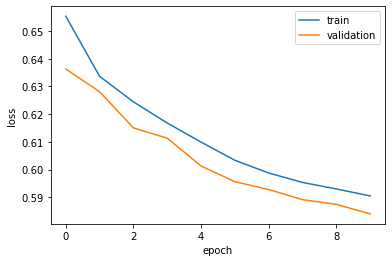

In [13]:
plotVsEpoch(history, 'loss')

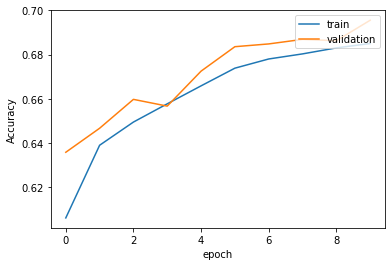

In [14]:
plotVsEpoch(history, 'Accuracy')

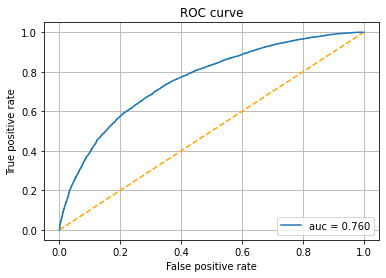

In [15]:
# apply model to get predictions on test set
y_pred = model.predict(x_test)

#draw ROC
drawROC2(y_test, y_pred)

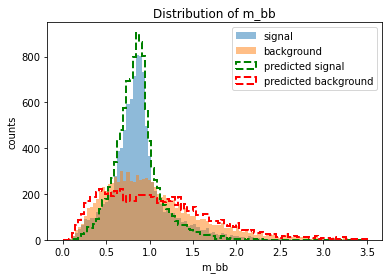

In [17]:
#plot signal vs background with prediction
variable = 'm_bb'

# Get the predicted probabilities for the positive class
y_pred_prob = model.predict(x_test)  # Use .ravel() to flatten to a 1D array

plotSignalvsBgWithPrediction2(x_test[variable], y_test, y_pred_prob, variable)

# Hyperparameters optimisation

- you can use [keras_tuner](https://keras.io/keras_tuner/) for hyperparameter optimisation

In [ ]:
# you may need to install it with
# !pip install --user keras-tuner

In [40]:
import keras_tuner as kt

# Define the model-building function
def build_model(hp):
    model = Sequential()

    # Tune the number of units in the hidden layers
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=256, step=32), activation='relu', input_dim=x_train.shape[1]))
    
    # Add a dropout layer - not a good idea because it is not used for inference
    # unwanted regularization effect that makes better accuracy on test than on train
    #model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    # Tune the learning rate for the optimizer
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, 
                  max_value=1e-2, sampling='LOG')), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model, 
    objective='val_accuracy',  # Optimization target
    max_trials=5,               # Number of models to try
    executions_per_trial=3,     # Number of executions for each trial
    directory='keras',         # Directory to store the results
    project_name='bigDataML'
)

# Run the hyperparameter search
%time tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Trial 5 Complete [00h 03m 34s]
val_accuracy: 0.6438000003496805

Best val_accuracy So Far: 0.6829499999682108
Total elapsed time: 00h 17m 16s
CPU times: user 42min 16s, sys: 16min 4s, total: 58min 20s
Wall time: 17min 16s
Best Hyperparameters:
Units: 224


KeyError: 'dropout does not exist.'

In [41]:
# Get the best model and parameters
best_model = tuner.get_best_models(num_models=1)[0]
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"Units: {best_params['units']}")
#print(f"Dropout: {best_params['dropout']}")
print(f"Learning Rate: {best_params['learning_rate']}")

# Evaluate the best model
test_loss, test_acc = best_model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Best Hyperparameters:
Units: 224
Learning Rate: 0.00782272621799324
625/625 [==============================] - 1s 1ms/step - loss: 0.5906 - accuracy: 0.6846
Test Loss: 0.5906
Test Accuracy: 0.6846


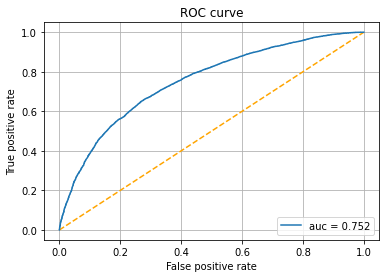

In [42]:
# apply model to get predictions on test set
y_pred = best_model.predict(x_test)

#draw ROC
drawROC2(y_test, y_pred)

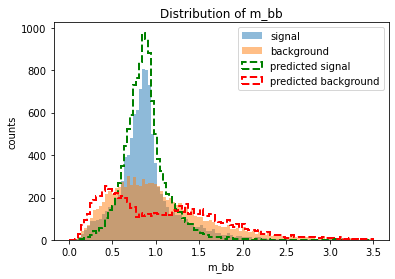

In [46]:
#plot signal vs background with prediction
variable = 'm_bb'

# Get the predicted probabilities for the positive class
y_pred_prob = best_model.predict(x_test)  # Use .ravel() to flatten to a 1D array

plotSignalvsBgWithPrediction2(x_test[variable], y_test, y_pred_prob, variable)

## Exercise 2

- play with the model parameters and see if you can improve the performances
- try to increase the number of epochs for training, is the model improving?
- how is training time affected by the number of parameters?
- how is signal versus background separation affected (check different variables)

In [47]:
# set batch size according to size of the input sample!!!
# start training with reasonable numer of epoch

%time history = best_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test), callbacks=[es]) #, verbose=0)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5876 - accuracy: 0.6880 - val_loss: 0.5861 - val_accuracy: 0.6887
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5867 - accuracy: 0.6893 - val_loss: 0.5867 - val_accuracy: 0.6890
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5874 - accuracy: 0.6890 - val_loss: 0.5875 - val_accuracy: 0.6877
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5865 - accuracy: 0.6894 - val_loss: 0.5903 - val_accuracy: 0.6872
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5873 - accuracy: 0.6884 - val_loss: 0.5863 - val_accuracy: 0.6847
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5858 - accuracy: 0.6890 - val_loss: 0.5830 - val_accuracy: 0.6937
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5854 - accuracy: 0.6897 - val_loss: 0.5862 - val_accuracy: 0.6837
Epoch 

In [49]:
# set batch size according to size of the input sample!!!
# start training with reasonable numer of epoch

%time history = best_model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test), callbacks=[es]) #, verbose=0)

Epoch 1/20
625/625 [==============================] - 2s 4ms/step - loss: 0.5810 - accuracy: 0.6928 - val_loss: 0.5851 - val_accuracy: 0.6877
Epoch 2/20
625/625 [==============================] - 2s 3ms/step - loss: 0.5809 - accuracy: 0.6928 - val_loss: 0.5824 - val_accuracy: 0.6841
Epoch 3/20
625/625 [==============================] - 2s 4ms/step - loss: 0.5806 - accuracy: 0.6920 - val_loss: 0.5800 - val_accuracy: 0.6945
Epoch 4/20
625/625 [==============================] - 2s 4ms/step - loss: 0.5795 - accuracy: 0.6939 - val_loss: 0.5784 - val_accuracy: 0.6959
Epoch 5/20
625/625 [==============================] - 2s 4ms/step - loss: 0.5785 - accuracy: 0.6960 - val_loss: 0.5816 - val_accuracy: 0.6987
Epoch 6/20
625/625 [==============================] - 2s 4ms/step - loss: 0.5785 - accuracy: 0.6949 - val_loss: 0.5818 - val_accuracy: 0.6973
Epoch 7/20
625/625 [==============================] - 2s 3ms/step - loss: 0.5781 - accuracy: 0.6954 - val_loss: 0.5792 - val_accuracy: 0.6870
Epoch 

In [50]:
model.summary()
#Total params: 3,001
#Wall time: 19.5 s (10 epoche)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer (Dense)               (None, 100)               2900      
                                                                 
 output (Dense)              (None, 1)                 101       
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


In [51]:
best_model.summary()
#Total params: 6,721
#Wall time: 23 s (10 epoche)
#Wall time: 44.8 s (20 epoche)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224)               6496      
                                                                 
 dense_1 (Dense)             (None, 1)                 225       
                                                                 
Total params: 6,721
Trainable params: 6,721
Non-trainable params: 0
_________________________________________________________________


In [60]:
# set batch size according to size of the input sample!!!
# start training with reasonable numer of epoch
model_t_study = keras.Sequential(
    [
        layers.Dense(800, activation="relu", name="layer", input_shape=(28,)),
        layers.Dense(1, activation="sigmoid", name="output")
    ]
)

# compile the model
model_t_study.compile(loss='binary_crossentropy', optimizer='adam', metrics='Accuracy')

print(model_t_study.summary())
%time history = model_t_study.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test), callbacks=[es]) #, verbose=0)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer (Dense)               (None, 800)               23200     
                                                                 
 output (Dense)              (None, 1)                 801       
                                                                 
Total params: 24,001
Trainable params: 24,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.6485 - Accuracy: 0.6177 - val_loss: 0.6316 - val_Accuracy: 0.6433
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6282 - Accuracy: 0.6467 - val_loss: 0.6276 - val_Accuracy: 0.6488
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6142 - Accuracy: 0.6633 - val_loss: 0.6089 - val_Accuracy: 0.6646
Epoch 4/10
625/

In [ ]:
# layers.Dense di 100 --> Total params: 3,001 and Wall time: 19.7 s s (10 epoche)
# layers.Dense di 200 --> Total params: 6,001 and Wall time: 21.4 s (10 epoche)
# layers.Dense di 300 --> Total params: 7,001 and Wall time: 22.3 s (10 epoche)
# layers.Dense di 600 --> Total params: 18,001 and Wall time: 29.2 s (10 epoche)
# layers.Dense di 800 --> Total params: 24,001 and Wall time: 32.7 s (10 epoche)

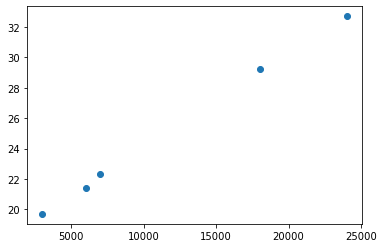

In [62]:
param = [3001, 6001, 7001, 18001, 24001]
time = [19.7, 21.4, 22.3, 29.2, 32.7]

plt.scatter(param, time)
plt.show()

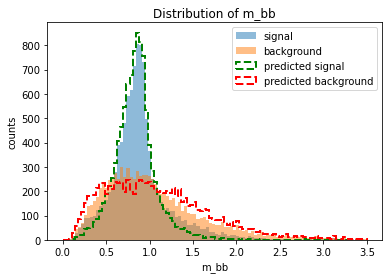

In [63]:
#plot signal vs background with prediction
variable = 'm_bb'

# Get the predicted probabilities for the positive class
y_pred_prob = model_t_study.predict(x_test)  # Use .ravel() to flatten to a 1D array

plotSignalvsBgWithPrediction2(x_test[variable], y_test, y_pred_prob, variable)